#### Group SBS, Sheet 04, Exercise 02

### Contributors:
- Binoy Chacko (chacko@uni-potsdam.de)
- Sreyas Sony (sony@uni-potsdam.de)
- Sanika Nair (nair@uni-potsdam.de)
- Dinesh Kumar (kumar@uni-potsdam.de)


In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Kalman Filter

In [2]:
class Kalman_filter():
    
    def __init__(self, observations, model_error_var=0.3, obs_err_var=0.5,  model_ini_var=0.5, n=5000):
        
        self.model_error_var = model_error_var
        self.obs_err_var = obs_err_var
        # inital state of the system
        self.Z0 = model_ini_var
        # no of updates needed based on observations
        self.n = n
        self.observations = observations
    
    @property
    def run_KF(self):
        """return analysis mean and analysis variance of the standard
        kalman filter"""
        # state estimate
        estimate_mu = np.zeros(self.n+1)
        estimate_var = np.zeros(self.n+1)
        #np.random.normal(0, self.Z0**0.5)
        estimate_mu[0] = 0
        estimate_var[0] = self.Z0
        
        for i in range(1, self.n+1):            
            # guess for the state of system based on model
            forecast_mean = 0.99*estimate_mu[i-1]
            forecast_var = 0.99**2 * estimate_var[i-1] + self.model_error_var       
            # kalman gain, 
            kalman_gain = forecast_var/(forecast_var + self.obs_err_var)
            # analysis_mean
            estimate_mu[i] = forecast_mean + kalman_gain*(self.observations[i-1] - forecast_mean)
            estimate_var[i] = (1 - kalman_gain)*forecast_var
        return estimate_mu, estimate_var      
         
    @staticmethod
    def mse(estimated, reference):
        return np.mean((estimated - reference)**2)
    
    @staticmethod
    def plot_ref_estimated(reference, estimate,  observations, xlim, ylim):
        x = np.arange(5001)
        plt.figure(figsize=(12,6))
        plt.scatter(x, reference, color="#377eb8", marker='o', alpha=0.7, s=20, label = 'Reference')
        plt.scatter(x[1:], observations, color='orange', marker='*', alpha=0.4, s=20, label = 'Observations')
        plt.plot(estimate, color='#e41a1c', lw=0.8, ls='-', label ='Estimated state', alpha=0.6)
        plt.xlabel("Time (a.u)")
        plt.ylabel("Signal amplitude (a.u)");
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.legend();
        plt.tight_layout()
        

### Ensemble Kalman filter

Standard Kalman filter works with the entire distribution of the state explicitly, whereas the EnKF stores, propagates, and updates an ensemble of vectors that approximates the state distribution.  It is an embodiment of the principle that an approximate solution to the right problem is worth more than a precise solution to the wrong problem [2]

In [3]:
class Ensemble_KF(Kalman_filter):
    
    def perturb_observations(self, observations, n_ensemble):
        obs_error_hat = np.random.normal(0, self.obs_err_var**0.5, n_ensemble)
        # centering model error
        obs_error_hat -= np.mean(obs_error_hat)
        return observations - obs_error_hat
        
    def run_ensemble_KF(self, n_ensemble):
        # initializing n_ensembles
        ensemble_ini = np.random.normal(0, self.Z0**0.5, n_ensemble)
        ensemble = np.zeros((self.n + 1, n_ensemble))
        ensemble[0] = ensemble_ini
        ensemble_mu = np.zeros(self.n+1)
        ensemble_covar = np.zeros(self.n+1)
        
        for i in range(1, self.n+1):
            # guess for the state of system based on model
            model_errors = np.random.normal(0, self.model_error_var**0.5, n_ensemble)
            forecast_ensemble = 0.99*ensemble[i-1] + model_errors
            # main difference between with kalman filter
            # computationally less expensive compared to standard
            # kalman filter for higher dimensions
            forecast_mean = np.mean(forecast_ensemble)
            # forecast deviation from mean
            A = forecast_ensemble - forecast_mean
            forecast_covar = A @ A.T/(n_ensemble-1)
            kalman_gain = forecast_covar/(forecast_covar + self.obs_err_var)
            # perturbed observations for correcting the low spread of analysis variance
            # Normally the observations come with the inherent measuremnet error.
            # Another consistent approach is to perturb model predicted observations 
            # with the measurement noise, since actual observations already contain errors[1]
            perturbed_obs = self.perturb_observations(self.observations[i-1], n_ensemble)
            ensemble[i] = forecast_ensemble + kalman_gain*(perturbed_obs - forecast_ensemble)
            ensemble_mu[i] = np.mean(ensemble[i])
            # analysis variance is not used in the calculations.
            # Analysis variance can be calculated using the
            # sample variance formula on the ensembles or by using the kalman gain formula. 
            # Both are equivalent. 
            # ensemble_covar[i] = (1-kalman_gain)*forecast_covar
            # analysis deviation from mean
            B = ensemble[i] - ensemble_mu[i]
            ensemble_covar[i] = B @ B.T /(n_ensemble-1)
        return ensemble_mu, ensemble_covar, ensemble       


def plot_compare_KF_enKF():
    
    plt.figure(figsize=(6, 4))
    plt.title("Comparison of KF and EnKF")
    plt.plot(reference[1:], 'k', alpha=0.8, label='Reference')
    plt.plot(state_estimates_SenKF[:,4], '--', label='state estimate-EnKF')
    plt.plot(KF_state_estimate[1:],'-.', label='state estimate-KF')
    plt.scatter(np.arange(5000), observations, color="blue", label="observations", alpha=0.6)
    plt.xlim(25,50)
    plt.ylim(-0.7,2.7)
    plt.xlabel("Time (a.u)")
    plt.ylabel("Signal amplitude(a.u)")
    plt.legend()
    plt.show()

### Estimating the state of the system using Kalman filter

In [4]:
np.random.seed(seed=2021)
# loading reference data and observations
reference = np.loadtxt("reference_signal.txt")
observations = np.loadtxt("data.txt")

# instantiating the class
KF = Kalman_filter(observations)
KF_state_estimate, KF_estimate_var = KF.run_KF

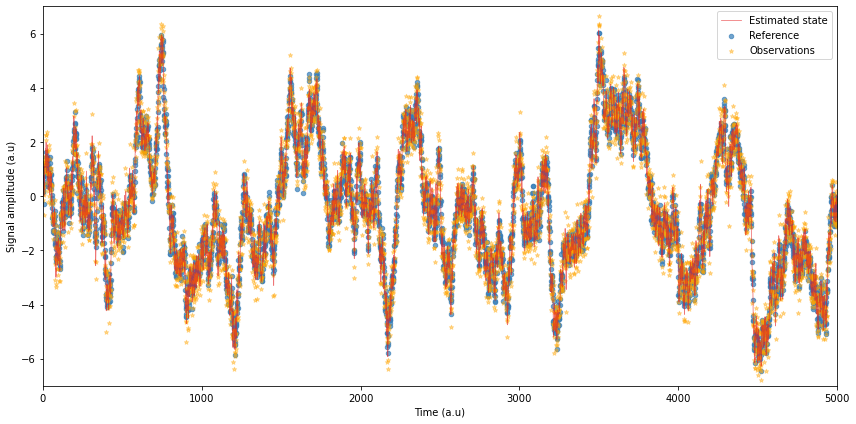

In [5]:
# plotting the estimates
KF.plot_ref_estimated(reference, KF_state_estimate, observations, xlim=(0,5001), ylim=(-7, 7))

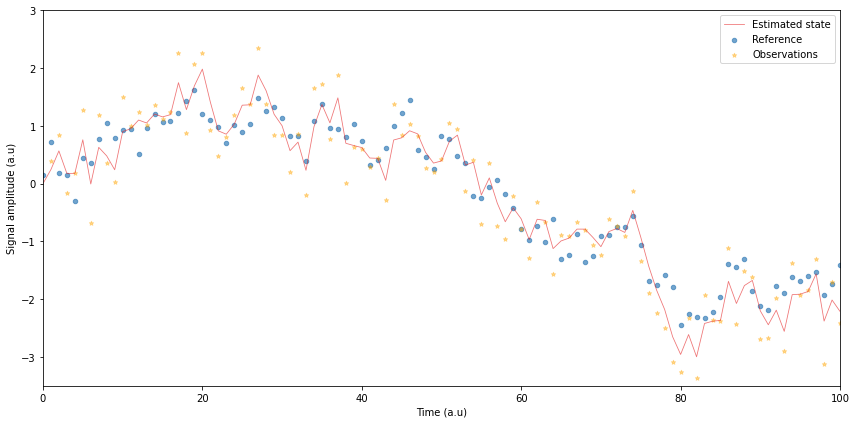

In [6]:
KF.plot_ref_estimated(reference, KF_state_estimate,observations, xlim=(0,100), ylim=(-3.5, 3))

#### MSE calculation

In [7]:
KF_mse = KF.mse(estimated=KF_state_estimate, reference=reference)
print(f"The mse value using Kalman filter is {KF_mse}")

The mse value using Kalman filter is 0.113510626882344


#
###  Estimating state of the system using Stohastic ensemble kalman filter

Stochastic ensemble Kalman filters, where the use of perturbed observations was introduced simultaneously by Burgers et al. (1998) and Houtekamer and Mitchell (1998) to correct the previously too low spread of the analysis ensemble [1].  

In [8]:
stohastic_EnKF = Ensemble_KF(observations)
M = [5, 10, 25, 50, 100]
state_estimates_SenKF = np.zeros((observations.shape[0], len(M)))
ensembles_SenKF = []
for i, m in enumerate(M):
    state_estimate, _, ensemble = stohastic_EnKF.run_ensemble_KF(n_ensemble=m)
    state_estimates_SenKF[:, i] = state_estimate[1:]
    ensembles_SenKF.append(ensemble)
    mse_m = KF.mse(state_estimate[1:], reference[1:])
    print(f"MSE for ensemble of size {m} is {mse_m}")

MSE for ensemble of size 5 is 0.15693708043446833
MSE for ensemble of size 10 is 0.13127310537538137
MSE for ensemble of size 25 is 0.12011287302001815
MSE for ensemble of size 50 is 0.11678495198612425
MSE for ensemble of size 100 is 0.11543221279580239


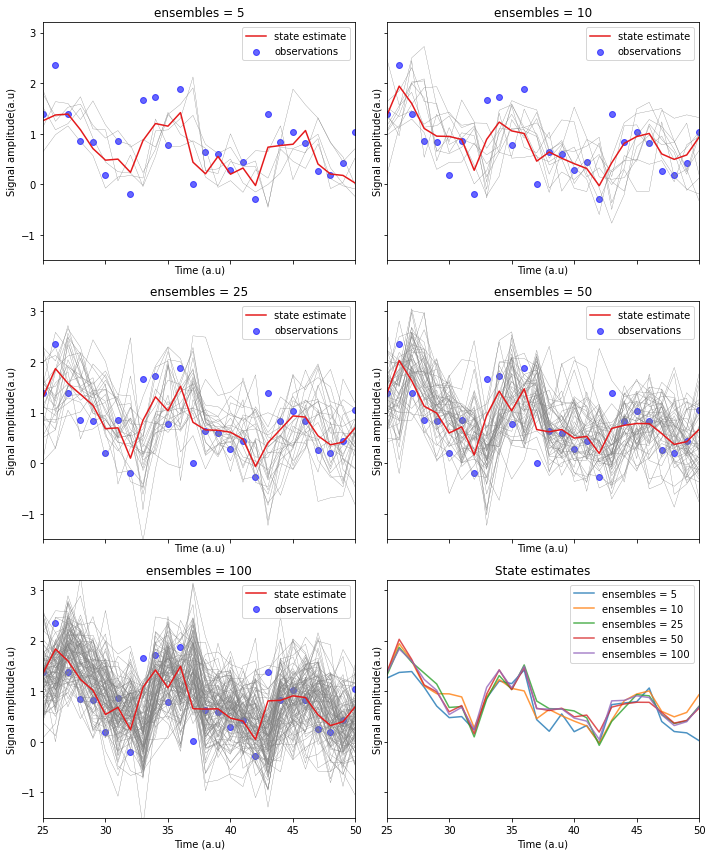

In [9]:
fig, axs = plt.subplots(3, 2, figsize=(10, 12), sharey=True,sharex=True)
axs = axs.flat
for i, ax in enumerate(axs[:-1]):
    ax.set_title(f"ensembles = {M[i]}")
    ax.plot(ensembles_SenKF[i], lw=0.3, color='grey')
    ax.plot(state_estimates_SenKF[:, i], color="#e41a1c", label="state estimate")
    ax.scatter(np.arange(5000), observations, color="blue", label="observations", alpha=0.6)
    ax.set_xlim(25,50)
    ax.set_xlabel("Time (a.u)")
    ax.set_ylabel("Signal amplitude(a.u)")
    ax.legend()

for i in range(state_estimates_SenKF.shape[1]):
    axs[-1].set_title("State estimates")
    axs[-1].plot(state_estimates_SenKF[:, i], label=f"ensembles = {M[i]}", alpha=0.8)
    axs[-1].legend()
    axs[-1].set_ylim(-1.5, 3.2)
axs[-1].set_xlabel("Time (a.u)")
axs[-1].set_ylabel("Signal amplitude(a.u)")
fig.tight_layout()
plt.show()    

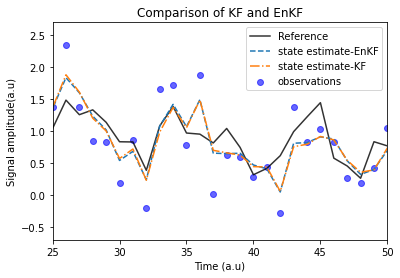

In [10]:
# comparisons of state estimation
plot_compare_KF_enKF()

As the size of the ensemble increases,  the MSE value decreases, which shows we are estimating the state of the system close to the reference system. This is clear from the above graphs as well. The difference in the state estimation  between the EnKF and the standard KF converges to zero when the size of the ensemble becomes large. In addition to the estimate, EnKF gives us the information of the uncertainty around the state estimate. As mentioned previously, to getter a better picture of the  propagation of uncertainty,  we added the perturbed observations in the EnKF, otherwise, while propagating the ensembles by sampling from the posterior and updating it, the spread of the uncertainity  becomes narrow.

### References


1) Sanita Vetra-Carvalho, The Ensemble Kalman filter Part I: Theory,  Data-assimilation training course.  7-10th  March 2018, University of Reading

2)  Matthias Katzfuss, Jonathan R. Stroud & Christopher K. Wikle (2016) Understanding the Ensemble Kalman Filter, The American Statistician, 70:4, 350-357.

